In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
tf.random.set_seed(42)

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
tf.random.set_seed(42)
latent_dim = 2

encoder_inputs = keras.Input(shape=(13,))
x = layers.Dense(32, activation="relu")(encoder_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           448         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           2112        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           1040        dense_1[0][0]                    
____________________________________________________________________________________________

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="sigmoid")(latent_inputs)
x = layers.Dense(32, activation="sigmoid")(x)
x = layers.Dense(16, activation="sigmoid")(x)
decoder_outputs = layers.Dense(13, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 13)                221       
Total params: 3,021
Trainable params: 3,021
Non-trainable params: 0
_________________________________________________________________


In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        tf.random.set_seed(42)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
#             print('Matriz: ',keras.losses.binary_crossentropy(data, reconstruction))
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=0
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
#             print(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [6]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [7]:
dataAll = pd.read_csv('housesToRentProcessed.csv')

valuesSaoPaulo = dataAll['São Paulo'].values
indexSaoPaulo = []
for i in range(dataAll.shape[0]):
    if valuesSaoPaulo[i] == 1:
        indexSaoPaulo.append(i)
len(indexSaoPaulo)

data = dataAll.iloc[:, :-1]
y = dataAll.iloc[:, -1:].values
data = data.values.astype(float)

# Normalizing
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)


vae.fit(data, epochs=30, batch_size=128)


z_mean, z_log_var, z = encoder.predict(data)
print(z_mean)


ZisProjetadosSaoPaulo = []
ZisResto = []
for i in range(z_mean.shape[0]):
    zi = z_mean[i]    
    if i in indexSaoPaulo:
        ZisProjetadosSaoPaulo.append([zi[0],zi[1]])
    else:
        ZisResto.append([zi[0],zi[1]])
    
ZisProjetadosSaoPaulo = np.array(ZisProjetadosSaoPaulo)
ZisResto = np.array(ZisResto)

pricesValue = y
pricesSaoPaulo = []
pricesResto = []
for i in range(len(pricesValue)):
    if i in indexSaoPaulo:
        pricesSaoPaulo.append(pricesValue[i])
    else:
        pricesResto.append(pricesValue[i])
        

Epoch 1/30
84/84 [==============================] - 1s 1ms/step - loss: 78.1864 - reconstruction_loss: 63.4387 - kl_loss: 0.0162
Epoch 2/30
84/84 [==============================] - 0s 1ms/step - loss: 33.6627 - reconstruction_loss: 29.1746 - kl_loss: 0.0027
Epoch 3/30
84/84 [==============================] - 0s 1ms/step - loss: 17.9469 - reconstruction_loss: 15.5973 - kl_loss: 8.0360e-04
Epoch 4/30
84/84 [==============================] - 0s 1ms/step - loss: 10.5587 - reconstruction_loss: 9.7738 - kl_loss: 2.2852e-04
Epoch 5/30
84/84 [==============================] - 0s 1ms/step - loss: 7.0236 - reconstruction_loss: 6.8973 - kl_loss: 1.1691e-04
Epoch 6/30
84/84 [==============================] - 0s 1ms/step - loss: 5.4014 - reconstruction_loss: 5.1954 - kl_loss: 5.5101e-05
Epoch 7/30
84/84 [==============================] - 0s 1ms/step - loss: 4.5502 - reconstruction_loss: 4.1012 - kl_loss: 5.4038e-05
Epoch 8/30
84/84 [==============================] - 0s 1ms/step - loss: 4.3394 - rec

In [8]:
mpl.rcParams['figure.figsize'] = (10, 8)

def plot_label_clusters(ZisProjetadosSaoPaulo, ZisResto, pricesSaoPaulo, pricesResto, limit=False):
    l1 = ZisProjetadosSaoPaulo[:,0]
    l2 = ZisProjetadosSaoPaulo[:,1]

    l1r = ZisResto[:,0]
    l2r = ZisResto[:,1]
    
    plt.scatter(l1, l2, c=pricesSaoPaulo, cmap="inferno", marker='v')
    plt.scatter(l1r, l2r, c=pricesResto, cmap="inferno", marker='o')
    
    if limit:
        plt.xlim(-0.25,1)
        plt.ylim(-2,2)

    plt.colorbar()
    plt.show()

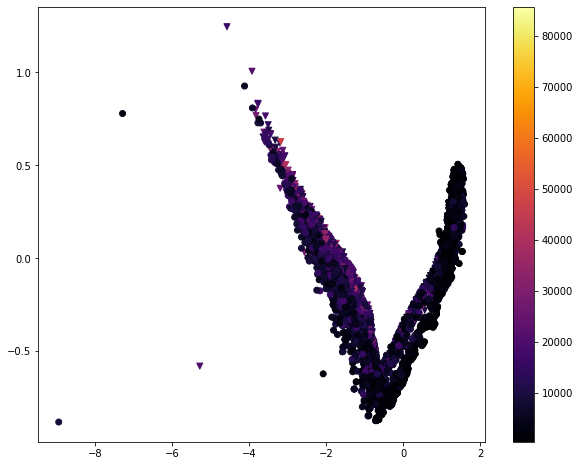

In [9]:
plot_label_clusters(ZisProjetadosSaoPaulo, ZisResto, pricesSaoPaulo, pricesResto)

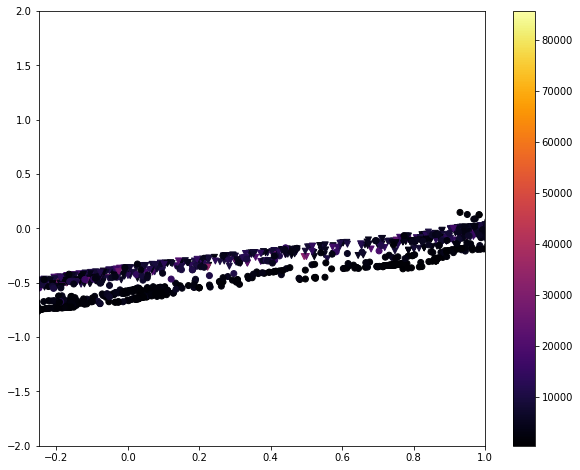

In [10]:
plot_label_clusters(ZisProjetadosSaoPaulo, ZisResto, pricesSaoPaulo, pricesResto, limit=True)

In [11]:
y1Log = np.log(pricesSaoPaulo)
y2Log = np.log(pricesResto)

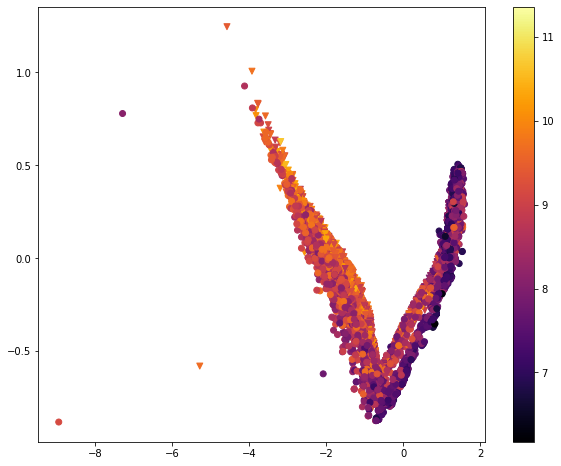

In [12]:
plot_label_clusters(ZisProjetadosSaoPaulo, ZisResto, y1Log, y2Log)

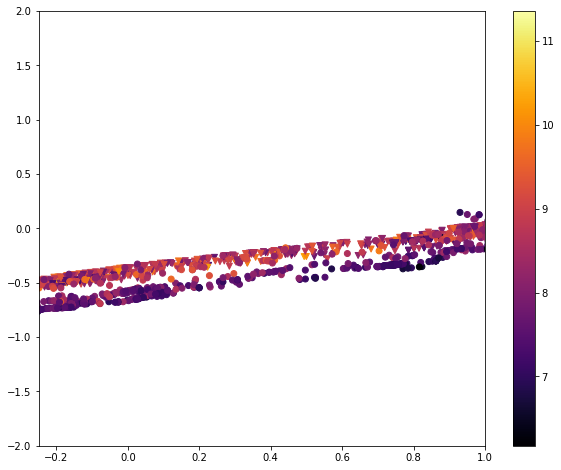

In [13]:
plot_label_clusters(ZisProjetadosSaoPaulo, ZisResto, y1Log, y2Log, limit=True)